In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

takeaway_db = '../databases/takeaway.db'
deliveroo_db ='../databases/deliveroo.db'
ubereats_db ='../databases/ubereats.db'

def query_db(db, sql_query):
    ''' input: db (path to SQLite database), sql_query (str)
        output: pandas DataFrame
    '''
    conn = sqlite3.connect(db)
    with conn:
        res = pd.read_sql_query(sql_query, conn)
    if conn:
        conn.close()
    return res

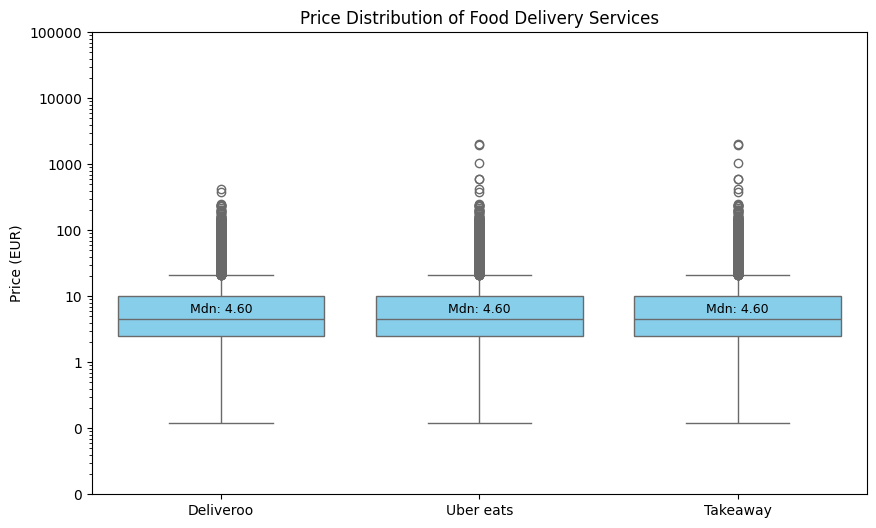

In [2]:
## Q: What is the price distribution of menu items?

query = """
    -- Deliveroo
    SELECT
        price, 'Deliveroo' AS service
    FROM
        menu_items
    WHERE
        id NOT IN (1078983574, 297241847, 297241848, 1258473919, 987159854, 1272748371)     --- exclude prices in cents on id's
        AND price > 0.1

        
    UNION ALL

    
    -- Uber Eats
    SELECT
        price, 'Uber eats' AS service
    FROM
        menu_items
    WHERE
        price > 0.1

        
    UNION ALL

    
    -- Takeaway
    SELECT
        price, 'Takeaway' AS service
    FROM
        menu_items
    WHERE
        price > 0.1
    """

df = query_db(deliveroo_db, query)


# Create boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='service', y='price', data=df, hue='service', palette='Set3', boxprops=dict(facecolor='skyblue'))

# Add the median values as text
median_values = df.groupby('service')['price'].median()
for i, service in enumerate(df['service'].unique()):
    median_value = median_values[service]
    plt.text(i, median_value + 1, f'Mdn: {median_value:.2f}', ha='center', color='black', fontsize=9)

# Customize the plot
plt.title('Price Distribution of Food Delivery Services')
plt.ylabel('Price (EUR)')
plt.xlabel('')
plt.yscale('log')
plt.yticks(ticks=plt.gca().get_yticks(), labels=[f'{int(x)}' for x in plt.gca().get_yticks()])
plt.ylim(bottom=0.01 )

plt.show()


In general prices are not higher than 150 EUR, with the outliers mostly being sushi, wine and combo deals.
For Uber Eats there's one outlier above this level (wine bottle), but for Deliveroo there are many more, mostly being wine bottles.
I suspect much more alcohol is being sold on this last platform since there seems to be no contol on the category it's being put in (for example, wine can be found in 'Dessert', 'Italian', 'Snacks', 'Chicken'... instead of 'Alcohol').

On the bottom side, all platforms have lots of zero-prices used to select options/flavour/extra's, so these were excluded from the boxplots.

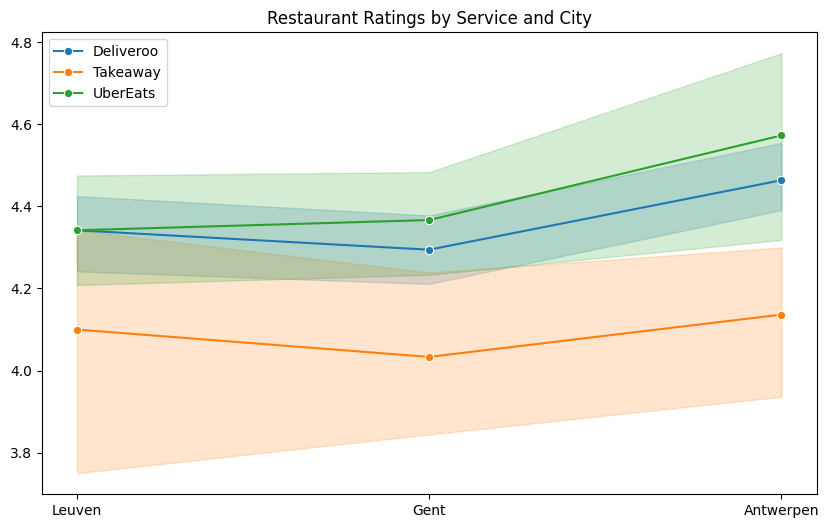

In [3]:
## Q: How do ratings of similar restaurants differ across Uber Eats, Deliveroo, and Takeaway?

# Connect to the main database
conn = sqlite3.connect('../databases/takeaway.db')

# Create a cursor object
cursor = conn.cursor()

# Attach the other databases
cursor.execute("ATTACH DATABASE '../databases/deliveroo.db' AS deliveroo")
cursor.execute("ATTACH DATABASE '../databases/ubereats.db' AS ubereats")

# Make the query
query1 = """
    SELECT
        t.name, t.city, 
        d.rating AS Deliveroo, t.ratings AS Takeaway, u.rating__rating_value AS UberEats
    FROM
        restaurants AS t
    INNER JOIN
        ubereats.restaurants AS u
        ON t.name = u.name AND t.postal_code = u.postal_code
    INNER JOIN
        deliveroo.restaurants AS d
        ON t.name = d.name AND t.postal_code = d.postal_code
    WHERE
        d.rating != 0.0 AND d.rating IS NOT NULL
        AND t.ratings != 0.0 AND t.ratings IS NOT NULL
        AND u.rating__rating_value != 0.0 AND u.rating__rating_value IS NOT NULL
        AND t.city IN ('Gent', 'Antwerpen', 'Leuven')
    ORDER BY
        Takeaway;
"""

# Load the query result into a DataFrame
df = pd.read_sql_query(query1, conn)

# Close the connection
conn.close()

# Display the results  (uncomment to review)
#display(df)


# Create lineplots
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='city', y='Deliveroo', label='Deliveroo', marker='o')
sns.lineplot(data=df, x='city', y='Takeaway', label='Takeaway', marker='o')
sns.lineplot(data=df, x='city', y='UberEats', label='UberEats', marker='o')

# Customize the plot
plt.title('Restaurant Ratings by Service and City')
plt.xlabel('')
plt.ylabel('')

# Show the plot
plt.show()

When looking at these three cities with 11 to 18 restaurants using all three delivery services, it becomes clear that users of Takeaway tend to give lower ratings, 
and Uber Eats gets the highest.
It's also remarkable that voters on Deliveroo are much more likeminded than those on the other platforms.
In Leuven the average scores are closest to one another, and the people from Antwerp like to give higher scores; this seems to align with the cliché of them believing their city is the greatest on the planet.

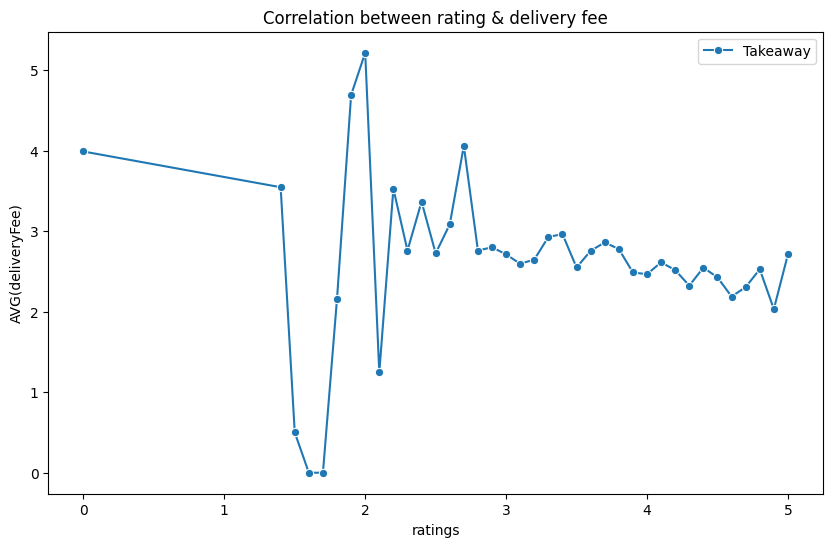

In [4]:
## Q: How do delivery fees vary across platforms and locations?

# Connect to the main database
conn = sqlite3.connect('../databases/takeaway.db')

# Create a cursor object
cursor = conn.cursor()

# Attach the Deliveroo database
cursor.execute("ATTACH DATABASE '../databases/deliveroo.db' AS deliveroo")

# Make the query
query_a = """
    SELECT
        t.city, t.deliveryFee, d.delivery_fee
    FROM
        restaurants AS t
    INNER JOIN
        deliveroo.restaurants AS d
        ON t.name = d.name AND t.postal_code = d.postal_code
    ORDER BY
        t.city
"""

# Load the query result into a DataFrame
df = pd.read_sql_query(query_a, conn)

# Close the connection
conn.close()

# Display the results
#display(df.head(50))


query_b = """
    SELECT
        AVG(deliveryFee), ratings
    FROM
        restaurants
    GROUP BY
        ratings
    """
df_takeaway = query_db(takeaway_db, query_b)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_takeaway, x='ratings', y='AVG(deliveryFee)', label='Takeaway', marker='o')
plt.title('Correlation between rating & delivery fee')
plt.show()

Uber Eats' website on delivery fees: "This fee varies based on your location. You pay less for nearby restaurants and you'll always know how much before selecting a restaurant."
This explains why there's no data on it in the database.

Deliveroo:
The standard delivery fee is 4.99 EUR. Out of the 318 restaurants I found working with both Deliveroo and Takeaway, only 5 had a different fee. Most of those are 0, situated in the vicinity of Brussels and Antwerp.

Takeaway:
There is a very extensive range of fees, indicating that restaurants themselves have the liberty of chosing it.
Only compared with rating, there is a clear and linear connection. Between ratings of 1.5 and 1.7 there is a huge dip, but this can be explained by the fact that there are only 4 entries for these values, and can therefore be ignored.